This notebook performs Latent Dirichlet allocation (LDiA) and Latent semantic analysis (LSA) topic modelling on film descriptions from IMDb.

# Imports

In [46]:
# Ignore deprecation warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
# !pip install scattertext
# !pip install pycontractions
# !pip install pyspellchecker

import pandas as pd
import numpy as np
import spacy
import nltk
import scattertext
import unicodedata
import matplotlib.pyplot as plt
import string
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import plotly.express as px
import plotly.graph_objects as go
from termcolor import colored
from sklearn.preprocessing import MultiLabelBinarizer
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from IPython.display import IFrame
from IPython.core.display import display, HTML
from spacy import displacy
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from matplotlib.pyplot import figure
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel, LsiModel
from pycontractions import Contractions
from sklearn.manifold import TSNE
from spellchecker import SpellChecker

%matplotlib inline

display(HTML("<style>.container { width:98% !important; }</style>"))
#nltk.download('stopwords')

# IMDb Dataset

Open the dataset, drop irrelevent columns and remove samples with missing information.

This dataset can be downloaded from Kaggle: https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset

In [14]:
# Read IMDb dataset
path = "IMDbMovies.csv.zip"
dataframe = pd.read_csv(path, low_memory=False)

# Read specific columns and drop and rows with NaN values
movies_data = dataframe[['title', 'description', 'genre']].dropna()
movies_data

title  \
0                          Miss Jerry   
1         The Story of the Kelly Gang   
2                      Den sorte drøm   
3                           Cleopatra   
4                           L'Inferno   
...                               ...   
85848                       Pengalila   
85849                       Manoharam   
85850                         Le lion   
85851  De Beentjes van Sint-Hildegard   
85854      La vida sense la Sara Amat   

                                             description  \
0      The adventures of a female reporter in the 1890s.   
1      True story of notorious Australian outlaw Ned ...   
2      Two men of high rank are both wooing the beaut...   
3      The fabled queen of Egypt's affair with Roman ...   
4      Loosely adapted from Dante's Divine Comedy and...   
...                                                  ...   
85848  An unusual bond between a sixty year old Dalit...   
85849  Manoharan is a poster artist struggling to fin...   
85850  A psychiatric hospital patient pretends to be ...   
85851  A middle-aged veterinary surgeon believes his ...   
85854  Pep, a 13-year-old boy, is in love with a girl...   

                           genre  
0                        Romance  
1        Biography, Crime, Drama  
2                          Drama  
3                 Drama, History  
4      Adventure, Drama, Fantasy  
...                          ...  
85848                      Drama  
85849              Comedy, Drama  
85850                     Comedy  
85851              Comedy, Drama  
85854                      Drama  

[83740 rows x 3 columns]

# Analysing the Dataset

### Metrics

Each film contains between 1 to 3 genres stored in `genre`. However, they are stored in the same column meaning some processing is required to separate each one to count the true number. For example, `Drama`, `Romance` and `Drama, Romance` would be counted as three different genres, even though only two unique genres are present.

In [15]:
def find_unique_genres(data):
    # Search all samples to find the genres types
    all_gens = []

    for genre_list in data['genre'].apply(lambda genre_list: genre_list.split(", ")):
        # Iterate through genre(s) for each film
        for genre in genre_list:
            # Remove whitespace
            all_gens.append(genre)

    # Create list of all unique genres
    unique_gens = list(set(all_gens))
    unique_gens.sort()
    return unique_gens, all_gens

unique_genres, all_genres = find_unique_genres(movies_data)

Print information about the dataset:
* When running on the full dataset, there are 25 genres in total.
* On average a film belongs to two genres meaning the average sample has two labels.
* Printing the shortest description length revealed that some descriptions do not have an adequate length, e.g. "Slip (", "McAllister (" and "Humble". Therefore a filter is applied later to remove samples where length is less than `min_length`.

In [16]:
tokenizer = RegexpTokenizer(r"\w+")

print(colored("Total number of films in IMDb dataset: ", color="blue", attrs=['bold']) + str(len(dataframe.index)) + "\n")
print(colored("Number of suitable films (samples): ", color="blue", attrs=['bold']) + str(len(movies_data.index)) + "\n")
print(colored("Number of films dropped: ", color="blue", attrs=['bold']) + str(len(dataframe.index) - len(movies_data.index)) + "\n")
print(colored("Total number of genres (labels): ", color="green", attrs=['bold']) + str(len(all_genres))  + "\n")
print(colored("Average number of genres per film: ", color="green", attrs=['bold']) + str(len(all_genres) / len(movies_data.index))  + "\n")
print(colored("Unique genres: ", color="green", attrs=['bold']) + str(unique_genres)  + "\n")
print(colored("Number of unique genres: ", color="green", attrs=['bold']) + str(len(unique_genres))  + "\n")
print(colored("Average description length: ", color="magenta", attrs=['bold']) + str(np.mean([len(desc) for desc in movies_data.description]))  + "\n")
print(colored("Average number of words in description: ", color="magenta", attrs=['bold']) + str(np.mean([len(tokenizer.tokenize(desc)) for desc in movies_data.description]))  + "\n")
print(colored("Average number of unique words in description: ", color="magenta", attrs=['bold']) + str(np.mean([len(set(tokenizer.tokenize(desc))) for desc in movies_data.description]))  + "\n")
print(colored("Shortest description length: ", color="magenta", attrs=['bold']) + str(min([len(tokenizer.tokenize(desc)) for desc in movies_data.description]))  + "\n")
print(colored("Longest description length: ", color="magenta", attrs=['bold']) + str(max([len(tokenizer.tokenize(desc)) for desc in movies_data.description]))  + "\n")

Total number of films in IMDb dataset: 85855

Number of suitable films (samples): 83740

Number of films dropped: 2115

Total number of genres (labels): 172461

Average number of genres per film: 2.059481729161691

Unique genres: ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

Number of unique genres: 25

Average description length: 160.06323143061857

Average number of words in description: 28.19075710532601

Average number of unique words in description: 25.13014091234774

Shortest description length: 1

Longest description length: 79



### Graphs

#### Scattertext graph of word occurence between genres

This produces a visual comparision between frequent words from a given genre and all other genres. For example, when `genre = 'Horror'`, the graph shows that words such as 'blood', 'rescue', 'children' appear frequently in horror film descriptions, but infrequently for other genres. These words are therefore useful indicators for identifying this genre. Similarly, words such as 'life' and 'mother' do not commonly appear in horror film descriptions and so their presence indicate a film is unlikely to be horror. Words such as 'film' and 'friends' appear to be common across many genres and so are unlikely to be helpful for identification. These could be removed along with regular stop words such as 'the' and 'of'.

In [17]:
genre = 'Horror' # Set as category to investigate

spacy.prefer_gpu()
# Load English language model
nlp = spacy.load("en_core_web_sm")

# Select 1000 random films to analyse
sample_movies = movies_data.sample(1000, random_state=1)

# Create a scatter text corpus
st_corpus = scattertext.CorpusFromPandas(sample_movies, category_col='genre', text_col='description', nlp=nlp).build()

# Plot graph
html = scattertext.produce_scattertext_explorer(st_corpus, category=genre, category_name=genre,
                                                not_category_name='Other Genre', width_in_pixels=1000,
                                                minimum_term_frequency=5, metadata=sample_movies['title'])

file_name = 'Scattertext_' + str(genre) + '.html'
open(file_name, 'wb').write(html.encode('utf-8'))
print(colored("Graph of frequent words in " + str(genre).lower() + " films compared to other genres", color="blue", attrs=['bold']))
IFrame(src=file_name, width=1200, height=700)

Graph of frequent words in horror films compared to other genres


#### Word frequency distribution of a given genre

Plot the most common words for a given genre. The first graph includes all words, although is dominated by stop words such as 'a', 'the', 'to'. The second graph has stop words removed. These are more characteristic of the genre, e.g "house" and "killer" for horror. The frequency distribution provide an interesting comparision against topics assigned through unsupervised topic modelling algorithms.

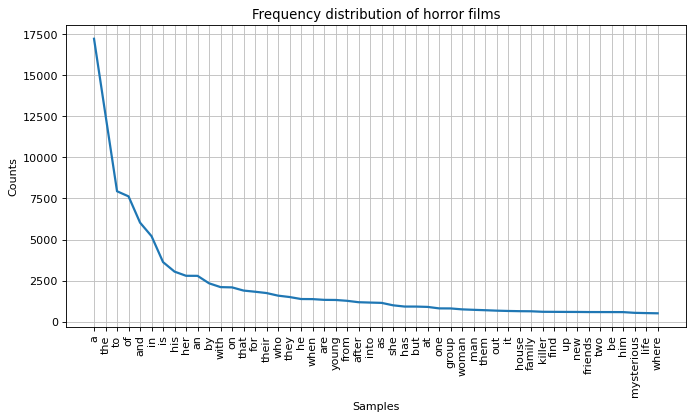

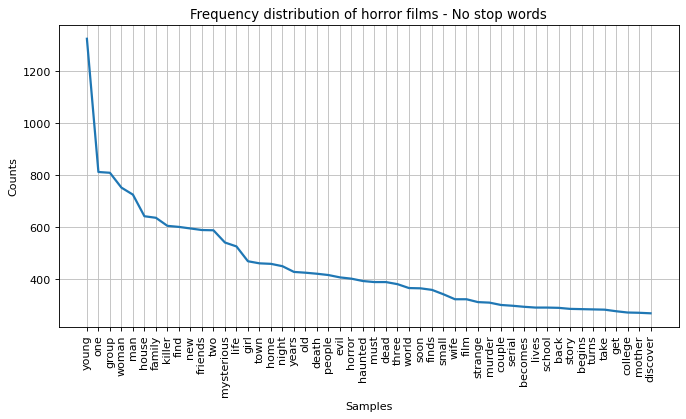

In [18]:
genre = "horror" # Set as category to investigate

film_descs = [] # Descriptions of all films in genre set above

# Iterate through genres + description of each films
for gen, desc in zip(movies_data.genre, movies_data.description):
    # Check if film has desired genre
    if genre in gen.lower():
        # Remove puncuation from description
        for char in string.punctuation:
            desc = desc.replace(char,"")
        # Add tokenized description to list
        film_descs.append(desc.split())

# Plot word frequency distribution
fd = FreqDist(word.lower() for sent in film_descs for word in sent)
figure(figsize=(10, 5), dpi=80)
plt.title("Frequency distribution of " + str(genre) + " films")
fd.plot(50)

# Plot word frequency distribution after removing stop words
figure(figsize=(10, 5), dpi=80)
stop_words = nltk.corpus.stopwords.words('english')
fd_no_stop = FreqDist(word.lower() for sent in film_descs for word in sent if word.lower() not in stop_words)
plt.title("Frequency distribution of " + str(genre) + " films - No stop words")
fd_no_stop.plot(50)
plt.show()

#### N-gram distribution

The first graph below display the most common bigrams across all genres. However, it is dominated by common stop word pairs. As stop words will be removed, I also plotted the most frequent bigrams after removing stop words. This reveals common characters such as "young man", "best friend" and "serial killer", as well as common places such as "high school" and "new york".

In [19]:
# String of all words in every description
all_desc_words = ''

# Add all descriptions to all_desc_words
for desc in movies_data.description:
    all_desc_words += desc

# Split list of all descriptions into tokens
all_tokens = tokenizer.tokenize(all_desc_words)

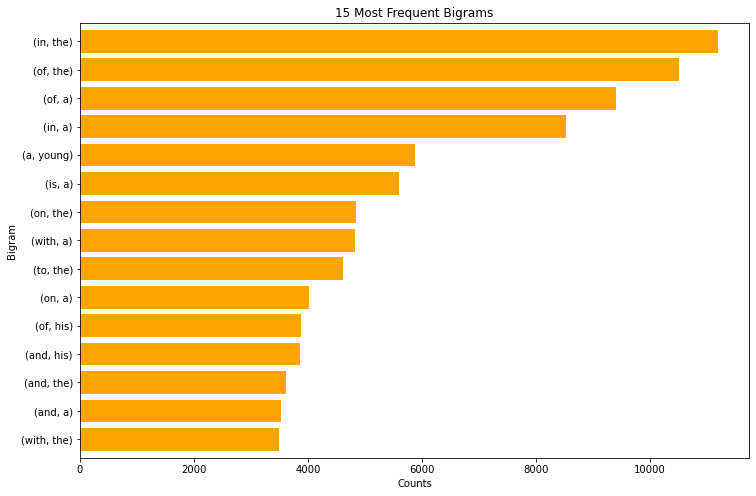

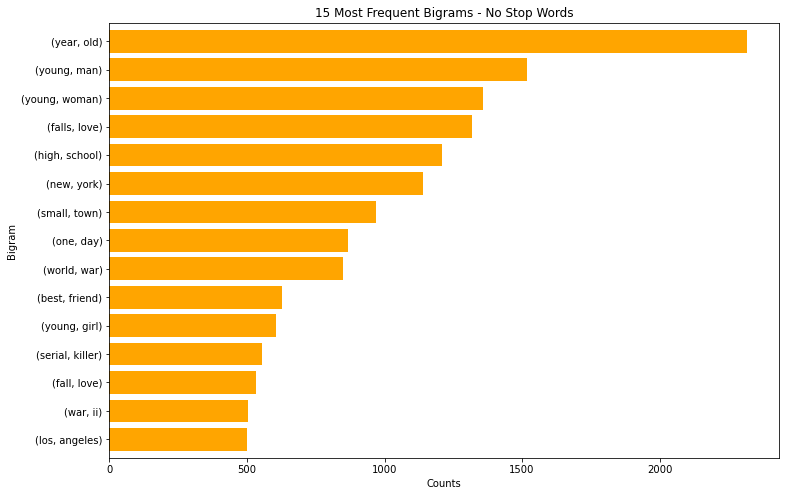

In [20]:
num = 15 # Number to display

# Get most frequent bigrams across all film descriptions
bigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens], 2)).value_counts())
bigrams[:num].sort_values().plot.barh(color='orange', width=0.8, figsize=(12, 8))
# Plot bigrams
plt.title(str(num) + " Most Frequent Bigrams")
plt.ylabel('Bigram')
plt.xlabel('Counts')
plt.show()

# Plot bigrams after removing stop words
bigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens if token.lower() not in stop_words], 2)).value_counts())
bigrams[:num].sort_values().plot.barh(color='orange', width=0.8, figsize=(12, 8))
plt.title(str(num) + " Most Frequent Bigrams - No Stop Words")
plt.ylabel('Bigram')
plt.xlabel('Counts')
plt.show()

Now I plot the most common trigrams. Again the first graph is dominated by stop words, while the second reveals common themes such as "world war ii", "new york city" and "based on a true story".

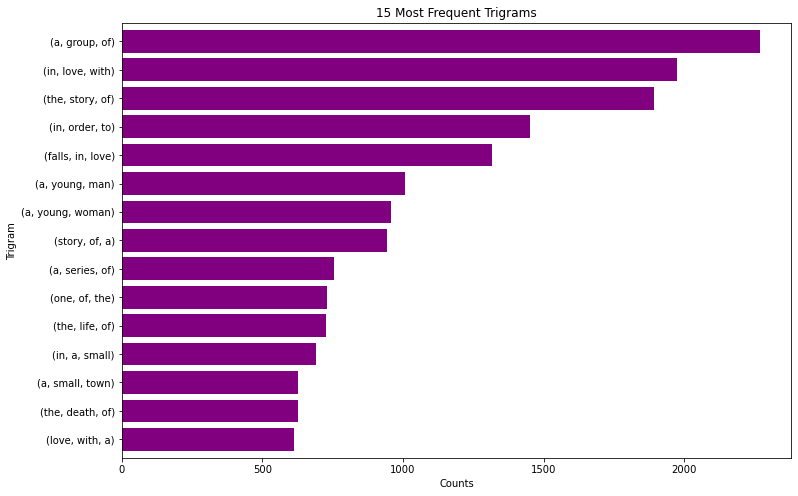

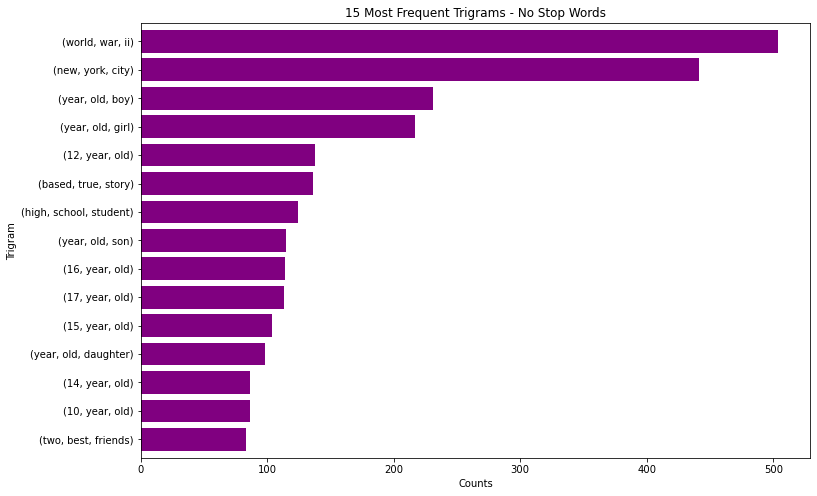

In [21]:
# Get most frequent trigrams across all film descriptions
trigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens], 3)).value_counts())
trigrams[:num].sort_values().plot.barh(color='purple', width=0.8, figsize=(12, 8))
# Plot trigrams
plt.title(str(num) + " Most Frequent Trigrams")
plt.ylabel('Trigram')
plt.xlabel('Counts')
plt.show()

# Plot trigrams after removing stop words
trigrams = (pd.Series(nltk.ngrams([token.lower() for token in all_tokens if token.lower() not in stop_words], 3)).value_counts())
trigrams[:num].sort_values().plot.barh(color='purple', width=0.8, figsize=(12, 8))
plt.title(str(num) + " Most Frequent Trigrams - No Stop Words")
plt.ylabel('Trigram')
plt.xlabel('Counts')
plt.show()

#### Label distribution

View the number of films belonging to each genre. Across all samples, the most common genres are Drama (26.7%), Comedy (16.4%) and Romance (8.0%). The least common is News with only one sample across the whole dataset. Other rare genres include Adult and Documentary which have two each, and Reality-TV which has three. After this is Film-Noir with 663. The rarest genres are removed later in the notebook as they do not provide enough samples to be representative.

In [22]:
# Count the number of genres
genre_counts = np.zeros(len(unique_genres))

for genre_list in movies_data['genre'].apply(lambda genre_list: genre_list.split(", ")):
    for i in range(len(unique_genres)):
        if unique_genres[i] in genre_list:
            genre_counts[i] += 1

# Print counts for each genre
# for gen, con in zip(unique_genres, genre_counts):
#     print(str(gen) + ": " + str(int(con)))
            
# Plot the interactive pie chart
fig = go.Figure()
fig.add_trace(go.Pie(labels=unique_genres, values=genre_counts))
fig.show()

#### Visualising word relationships with displaCy

The graph below shows syntactic dependencies and part-of-speech tags. This gives a visual representation of the relationships between words in a description that should be captured by the LSTM.

In [23]:
film_desc = sample_movies.description.iloc[1]
sample_doc = nlp(film_desc)
print(colored("Entity recognition of the description:", color="blue", attrs=['bold']))
displacy.render(sample_doc, style='ent', jupyter=True)

print(colored("\nDependency and POS tags:", color="blue", attrs=['bold']))
displacy.render(sample_doc, style='dep', jupyter=True)

Entity recognition of the description:



Dependency and POS tags:


# Data Processing

### Drop samples

As the dataset is large, samples are dropped so that the notebook can run in a reasonable time. `n_samples` specifies the number of samples to use. Setting `n_samples = 0` will cause all suitable samples to be used, although the notebook will be slow to run. For these experiments I have used 5000 samples as this provides a sufficient amount to perform topic modelling in a reasonable amount of time.

`min_length` specifies the minimum number of words in a description and samples less than this will be removed.

Setting `remove_rare_genres = True` will remove samples labelled as a genre with less than `rare_count` samples, e.g. if `rare_count = 10`, News, Adult, Documentary and Reality-TV are removed. For this project, `rare_count` has been set to 7500 so that only the top 7 most common genres are used. Using the most common genres also ensure that enough samples of each are provided.

In [24]:
n_samples = 5000
min_length = 10
remove_rare_genres = True
rare_count = 7500

# Create copy of movies_data
sampled_movies_data = movies_data

# Remove samples where description size is less than min_length
for i, desc in zip(sampled_movies_data.index, sampled_movies_data.description):
    if(len(tokenizer.tokenize(desc))) < min_length:
        sampled_movies_data = sampled_movies_data.drop(i)
        
if remove_rare_genres:
    # Find rare genres
    rare_genres = []
    
    for gen, count in zip(unique_genres, genre_counts):
        if count < rare_count:
            rare_genres.append(gen)
    print(colored("Genres removed: ", color="blue", attrs=['bold']) + str(rare_genres))
    
    for i, genre_list in zip(sampled_movies_data.index, sampled_movies_data['genre'].apply(lambda genre_list: genre_list.split(", "))):
        # Remove rare genres from list of film's genres
        new_genre_list = [gen for gen in genre_list if gen not in rare_genres]
        # Check if any genres remain
        if new_genre_list != []:
            # Update film's genre column
            sampled_movies_data.at[i,'genre'] = ", ".join(new_genre_list)
        else:
            # Else drop samples if all genres removed
            sampled_movies_data = sampled_movies_data.drop(i)

# Select n samples
if n_samples > 0:
    sampled_movies_data = sampled_movies_data.sample(n_samples, random_state=1)
sampled_movies_data

Genres removed: ['Adult', 'Adventure', 'Animation', 'Biography', 'Documentary', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Sci-Fi', 'Sport', 'War', 'Western']


title  \
61142       Eine ganz heiße Nummer   
11581              Nunca pasa nada   
79128             Seni Seven Ölsün   
25583  Storia di fantasmi cinesi 2   
65411                Transcendence   
...                            ...   
55764               De ofrivilliga   
22987     La protesta del silenzio   
31517         Pásla kone na betóne   
21825              Bir avuç cennet   
61547                        Guido   

                                             description  \
61142  When their little supermarket is threatened by...   
11581  A young French cabaret showgirl spends a few d...   
79128  The tragic-comic story chronicles the struggle...   
25583  In this installment of a phenomenal saga of th...   
65411  A scientist's drive for artificial intelligenc...   
...                                                  ...   
55764  In several unrelated stories, the consequences...   
22987  A little league player named Chuck refuses to ...   
31517  Johanka (Milka Zimkova) had a fling with a wel...   
21825  A family migrates to big city with hopes to pu...   
61547  An Iraqi immigrant hit man, GUIDO, gets mixed ...   

                        genre  
61142                  Comedy  
11581                   Drama  
79128                  Comedy  
25583          Action, Comedy  
65411           Action, Drama  
...                       ...  
55764                   Drama  
22987                   Drama  
31517  Comedy, Drama, Romance  
21825                   Drama  
61547                  Action  

[5000 rows x 3 columns]

### Samples

###### Stop words

Create a custom stop word list `movie_stop_words` of the most common words across all movie descriptions.

In [25]:
# Calculate frequency distribution to find most common words
movie_fd = FreqDist(token.lower() for token in all_tokens)

# Create custom stop word list
movie_stop_words = [word[0] for word in movie_fd.most_common(50)]
print(colored("Movie description stop words: ", color="blue", attrs=['bold']) + str(movie_stop_words)  + "\n")

Movie description stop words: ['a', 'the', 'to', 'of', 'and', 'in', 'his', 'is', 'with', 'her', 'an', 's', 'he', 'for', 'who', 'on', 'by', 'their', 'from', 'that', 'when', 'as', 'young', 'she', 'they', 'but', 'are', 'after', 'has', 'life', 'man', 'at', 'two', 'him', 'one', 'love', 'up', 'woman', 'it', 'into', 'family', 'out', 'story', 'new', 'about', 'old', 'be', 'girl', 'this', 'father']



Select which stop word list to use and print it. Set `stop = 0` to use no pre-defined stop word list, `stop = 1` to use NLTK, or any other value, e.g. `stop = -1`, for spaCy. Set `add_custom_words = True` to add the `movie_stop_words` to the stop words.


Here I have used NLTK to filter out common words that do not contribute to the meaning of the descriptions. This prevents unrepresentative words being picked up by the all the topics in the topic modelling algorithms.

In [26]:
stop = 1
add_custom_words = True

if stop == 0:
    # No stop words
    stop_words = []
elif stop == 1:
    # NLTK stop words
    stop_words = nltk.corpus.stopwords.words('english')
else:
    # spaCy stop words
    stop_words = list(spacy.lang.en.stop_words.STOP_WORDS)

if add_custom_words:
    # Add custom stop words to list
    stop_words = list(set(stop_words + movie_stop_words))
    
if stop_words:
    # Print stop word list if not empty
    print(colored("Stop words: ", color="blue", attrs=['bold']) + str(stop_words)  + "\n")
    print(colored("Number of stop words: ", color="blue", attrs=['bold']) + str(len(stop_words)))

Stop words: ['about', "hadn't", 'were', 'their', "needn't", "shouldn't", 'so', 'shan', "haven't", 'those', "you're", 'once', 'how', "hasn't", 'now', "won't", "should've", 'above', 'themselves', 'some', 'my', 'o', "aren't", "that'll", 'our', 'didn', 'it', 'and', 'under', 'does', 'ours', 'its', 'can', "couldn't", 'love', 'i', 'why', 'again', 'being', 'your', 're', 'yourself', 'after', 'weren', 'when', 'isn', 'was', 'theirs', 'who', "mightn't", 'which', 'be', 'before', 'other', 'itself', 'not', 'don', 'an', 'of', 'll', 'y', "isn't", 'or', "you'll", "wouldn't", 'mustn', 'than', 'on', 'ma', 'whom', "it's", 'that', 'for', 'by', 'up', 'will', 'himself', 'is', 'into', 'too', 'one', 'hasn', 'mightn', 'out', 'have', 'did', 'having', 'then', 'young', 'to', 'if', "doesn't", 'should', 'she', 'wouldn', 'a', 'aren', 'his', 'am', 'we', 'wasn', 'her', 'where', 'm', 't', 'herself', 'such', "you've", 'you', 'these', 'hers', 'both', 'ourselves', 'very', 'below', 'couldn', 'because', 'life', 's', 'any', 'a

###### Normalisation

Create a function to convert accented characters. For example, è becomes e in "Arsène Baudu and Hyacinthe, a pair of small-time crooks".

In [27]:
def remove_accents(text):
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(text)

print(colored("Before: ", color="blue", attrs=['bold']) + "Arsène Baudu and Hyacinthe, a pair of small-time crooks")
print(colored("After: ", color="blue", attrs=['bold']) + str(remove_accents("Arsène Baudu and Hyacinthe, a pair of small-time crooks")))

Before: Arsène Baudu and Hyacinthe, a pair of small-time crooks
After: Arsene Baudu and Hyacinthe, a pair of small-time crooks


Load a model to produce contractions, e.g. can't becomes cannot in "They fall in love, but can't quite seem to get the timing right."

In [28]:
# Load pre-trained word embedding
contraction = Contractions(api_key="glove-twitter-25")

print(colored("Before: ", color="blue", attrs=['bold']) + "They fall in love, but can't quite seem to get the timing right.")
print(colored("After: ", color="blue", attrs=['bold']) + list(contraction.expand_texts(["They fall in love, but can't quite seem to get the timing right."], precise=True))[0])

Before: They fall in love, but can't quite seem to get the timing right.
After: They fall in love, but cannot quite seem to get the timing right.


###### Processing samples

Process film descriptions and store as `description_docs`
1. Normalisation by removing accents and contractions
2. Split descriptions into sentences and perform tokenisation
3. Remove puncuation
4. Remove stop words (optional)
5. Correct spelling (optional)
5. Apply lemmatizing or stemming (optional)

In [29]:
def process_text_samples(data, stop_list=[], spell_correct=False, lemmatize=False, stem=False, stemmer_algorithm="porter"):
    # List of all samples
    samples = []
    
    # Create spell checker
    spell_check = SpellChecker()
    
    for sample in data:
        # Change accented characters, e.g à -> a
        sample = remove_accents(sample)
        # Contract words, e.g hasn't -> has not
        contracted = list(contraction.expand_texts([sample], precise=True))
        contracted = ''.join(contracted)
        # Input sample text into spaCy language processor
        doc = nlp(contracted)
        # Split sample text into sentences
        sentences = list(doc.sents)
        for i in range(len(sentences)):
            # Remove punctuation tokens, e.g. ! , .
            sentences[i] = [token for token in sentences[i] if not token.is_punct]
            
            # Remove stop words
            if stop_list:
                sentences[i] = [token for token in sentences[i] if token.text.lower() not in stop_list]
                
            # Correct spelling mistakes, e.g. "athiest" -> "atheist"
            if spell_correct:
                sentences[i] = [nlp(spell_check.correction(token.text))[0] for token in sentences[i]]
            
            # Apply lemmatization
            if lemmatize:
                # Resolve words to their dictionary form using PoS tags
                sentences[i] = [token.lemma_.lower() for token in sentences[i]]
                
            # Apply stemming (only if lemmatization not applied)
            elif stem:
                # Set stemmer type
                if stemmer_algorithm[0].lower() == "s":
                    # Snowball stemmer is advancement on Porter
                    stemmer = SnowballStemmer(language='english')
                else:
                    # Default to Porter stemmer if not specified
                    stemmer = PorterStemmer()
                # Stem tokens
                for j in range(len(sentences[i])):
                    # Apply stemmer to each word
                    stemmed = stemmer.stem(sentences[i][j].text)
                    # Convert back to type Token and update word in sentence
                    sentences[i][j] = nlp(stemmed)[0]
                    
            # Remove remaining punctuation within tokens, e.g. "(years)" -> "years", not including -
            sentences[i] = [token.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~')) for token in sentences[i]]
            sentences[i] = [token for token in sentences[i]]
            
        # Split words containing dash, e.g. "16-year" -> "16" + "year"
        for k in range(len(sentences)):
            new_sentence = []
            for token in sentences[k]:
                split_token = token.split('-')
                for word in split_token:
                    # Check word not empty
                    if word:
                        new_sentence.append(word)
            # Replace words in sentence
            sentences[k] = new_sentence
                    
        # Remove empty lists from list of sentences
        sentences = [sent for sent in sentences if sent != []]
        samples.append(sentences)
        
    return samples

# List of description 'documents' seperated into sentences
description_docs = process_text_samples(data=sampled_movies_data.description,
                                        spell_correct=False, 
                                        stop_list=stop_words,
                                        lemmatize=True)

# View extract
print(colored("First 5 descriptions:", color="blue", attrs=['bold']))
for i in range(5):
    print(colored(str(i), color="blue", attrs=['bold']) + " " + str(description_docs[i]))

First 5 descriptions:
0 [['little', 'supermarket', 'threaten', 'bankruptcy', 'three', 'shop', 'assistant', 'rural', 'bavaria', 'start', 'phone', 'sex', 'line']]
1 [['french', 'cabaret', 'showgirl', 'spend', 'day', 'provincial', 'spanish', 'city', 'recover', 'operation', 'alter', 'brash', 'self', 'confidence', 'narrow', 'minded', 'custom', 'place']]
2 [['tragic', 'comic', 'chronicle', 'struggle', 'lover', 'duel', 'family', 'try', 'end', 'ancient', 'spell', 'cast', 'upon', 'black', 'sea', 'village', 'prevent', 'love', 'one', 'come', 'together']]
3 [['installment', 'phenomenal', 'saga', 'super', 'natural', 'four', 'people', 'catch', 'tug', 'war', 'evil', 'imperial', 'wizard', 'corrupt', 'general'], ['outrageous', 'special']]
4 [['scientist', 's', 'drive', 'artificial', 'intelligence', 'take', 'dangerous', 'implication', 'consciousness', 'upload', 'program']]


Again I have a filter to remove samples if they contain less words than `min_words`. This is because removing stop words in the code above will sometimes make some descriptions too short which makes them unsuitable for model training.

In [30]:
min_words = 5

# Convert docs in description_docs from list of sentences to list of words
word_docs = []

for doc in description_docs:
    # Make a list of all words
    words = [word for sent in doc for word in sent]
    if len(words) >= min_words:
        word_docs.append(words)

# Unsupervised Topic Modelling

Convert the list of films into a form suitable for LDiA and LSA. A dictionary is constructed mapping each word to its integer id. This dictionary is used to construct a document-term matrix.

In [31]:
# Construct a dictionary mapping words to their integer ids
word_id_dict = corpora.Dictionary(word_docs)
# Build a document-term matrix from the list of documents
corpus = [word_id_dict.doc2bow(doc) for doc in word_docs]

# View corpus
pd.DataFrame(corpus)

0         1         2          3          4          5   \
0       (0, 1)    (1, 1)    (2, 1)     (3, 1)     (4, 1)     (5, 1)   
1      (13, 1)   (14, 1)   (15, 1)    (16, 1)    (17, 1)    (18, 1)   
2      (31, 1)   (32, 1)   (33, 1)    (34, 1)    (35, 1)    (36, 1)   
3      (52, 1)   (53, 1)   (54, 1)    (55, 1)    (56, 1)    (57, 1)   
4      (69, 1)   (70, 1)   (71, 1)    (72, 1)    (73, 1)    (74, 1)   
...        ...       ...       ...        ...        ...        ...   
4974   (76, 1)  (204, 1)  (565, 1)  (1158, 1)  (1251, 1)  (1552, 1)   
4975    (4, 1)    (9, 1)   (76, 1)   (299, 1)   (404, 1)   (465, 1)   
4976  (176, 1)  (226, 1)  (812, 1)   (927, 1)  (2217, 1)  (2725, 1)   
4977   (16, 2)   (24, 1)  (138, 1)   (190, 1)   (316, 1)   (340, 1)   
4978   (84, 1)  (233, 1)  (318, 1)   (323, 1)   (403, 1)   (766, 1)   

             6          7           8           9   ...    26    27    28  \
0        (6, 1)     (7, 1)      (8, 1)      (9, 1)  ...  None  None  None   
1       (19, 1)    (20, 1)     (21, 1)     (22, 1)  ...  None  None  None   
2       (37, 1)    (38, 1)     (39, 1)     (40, 1)  ...  None  None  None   
3       (58, 1)    (59, 1)     (60, 1)     (61, 1)  ...  None  None  None   
4       (75, 1)    (76, 1)     (77, 1)     (78, 1)  ...  None  None  None   
...         ...        ...         ...         ...  ...   ...   ...   ...   
4974  (1877, 1)  (3910, 1)  (13268, 1)        None  ...  None  None  None   
4975   (598, 1)   (786, 1)   (1054, 1)   (1844, 1)  ...  None  None  None   
4976  (3093, 1)  (6317, 1)   (9174, 1)  (10901, 1)  ...  None  None  None   
4977   (525, 1)   (599, 1)    (657, 1)    (660, 1)  ...  None  None  None   
4978   (896, 1)   (972, 1)   (1024, 1)   (1206, 1)  ...  None  None  None   

        29    30    31    32    33    34    35  
0     None  None  None  None  None  None  None  
1     None  None  None  None  None  None  None  
2     None  None  None  None  None  None  None  
3     None  None  None  None  None  None  None  
4     None  None  None  None  None  None  None  
...    ...   ...   ...   ...   ...   ...   ...  
4974  None  None  None  None  None  None  None  
4975  None  None  None  None  None  None  None  
4976  None  None  None  None  None  None  None  
4977  None  None  None  None  None  None  None  
4978  None  None  None  None  None  None  None  

[4979 rows x 36 columns]

Create a function to plot an interactive t-SNE graph.

In [32]:
def plot_tSNE(model, title="t-SNE"):
    # Create list of topic weights from corpus
    topic_weights = []
    for i, row in enumerate(model[corpus]):
        topic_weights.append([weight for i, weight in row])
        
    # Pad weights to same length by filling with 0s
    padded_weights = pd.DataFrame(topic_weights).fillna(0).values
    # Find the dominant topic number in each document
    dominant_topics = np.argmax(padded_weights, axis=1)
    
    # Perform t-SNE dimensionality reduction
    tSNE_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
    tsne_features = tSNE_model.fit_transform(padded_weights)
    
    # Plot the graph against first two components
    fig = px.scatter(x=tsne_features[:,0], y=tsne_features[:,1], color=dominant_topics, width=1200)
    fig.update_layout(title=title)
    fig.show()

Define a function to find the best k number of topics for either LDiA or LSA.

In [33]:
def find_best_k(corp, id2word, model_type="LDiA"):
    # Record coherence score of each k value
    k_scores = []

    # Test different k values
    for k in range(2, 48, 5):
        # Create model
        if model_type.lower() == "lsa":
            model = LsiModel(corp, id2word=id2word, num_topics=k)
        else:
            model = LdaMulticore(corp, id2word=id2word, num_topics=k)
        # Calculate coherence score
        coherence_model = CoherenceModel(model=model, texts=word_docs, dictionary=word_id_dict, coherence='c_v')
        # Record score for k
        k_scores.append([k, coherence_model.get_coherence()])
    
    k_scores_df = pd.DataFrame(k_scores, columns=['Number of Topics', 'Coherence Score'])
    k_scores_df = k_scores_df.set_index('Number of Topics')
    return k_scores_df

### Latent Dirichlet Allocation (LDiA)

LDiA is a commonly used unsupervised machine learning algorithm used for topic modelling. For this project, the aim is to find hidden clusters of similarity between some descriptions, and to find distinguishing features of others.

#### LDiA on expected number of topics

As I selected the top 7 most common genres, it makes sense to see how the unsupervised algorithms categorise films into this many topics. However, as this technique is unsupervised, topics do not always correspond to a genre. This can be observed by comparing the common words of each topic in the graph below to the frequency distribution of genres in an earlier section. LDiA is therefore picking up on hidden patterns that may not be apparent to a human.

1. Perform LDiA on all samples, setting the number of topics as the number of unique genres
2. Calculate the coherence score
3. Plot the results
4. Optimise the model parameters

In [34]:
use_optimised_params = True

# Set number of topics
sampled_unique_genres, sampled_all_genres = find_unique_genres(sampled_movies_data)
k_topics = len(sampled_unique_genres)

# Optimal parameters found in section below
optimal_alpha = 0.3
optimal_eta = 0.3

if use_optimised_params:
    # Create model with best alpha and eta
    LDiA_model = LdaMulticore(corpus, id2word=word_id_dict, num_topics=k_topics, alpha=optimal_alpha, eta=optimal_eta)
else:
    # Create model with default alpha and eta
    LDiA_model = LdaMulticore(corpus, id2word=word_id_dict, num_topics=k_topics)

# Calculate coherence score
LDiA_coherence_model = CoherenceModel(model=LDiA_model, texts=word_docs, dictionary=word_id_dict, coherence='c_v')
print(colored("Coherence score: ", color="blue", attrs=['bold']) + str(LDiA_coherence_model.get_coherence()) + "\n")

# Print topic keywords
topic_scores = LDiA_model.print_topics(num_topics=k_topics)
print(colored("Topic keywords:", color="blue", attrs=['bold']))
for i in range(len(topic_scores)):
    print(colored(str(i) + " ", color="blue", attrs=['bold']) + str(topic_scores[i][1:]))
print("")

# Display graph of topic distribution
vis_data = gensim_models.prepare(LDiA_model, corpus, word_id_dict)
pyLDAvis.display(vis_data)

Coherence score: 0.13787929581423156

Topic keywords:
0 ('0.009*"s" + 0.007*"friend" + 0.006*"year" + 0.005*"boy" + 0.004*"live" + 0.004*"find" + 0.004*"take" + 0.003*"son" + 0.003*"get" + 0.003*"town"',)
1 ('0.005*"get" + 0.004*"take" + 0.004*"school" + 0.003*"friend" + 0.003*"high" + 0.003*"year" + 0.003*"try" + 0.003*"wife" + 0.003*"film" + 0.003*"leave"',)
2 ('0.019*"s" + 0.005*"get" + 0.005*"become" + 0.004*"year" + 0.004*"world" + 0.003*"live" + 0.003*"take" + 0.003*"day" + 0.003*"friend" + 0.003*"work"',)
3 ('0.008*"s" + 0.006*"find" + 0.005*"go" + 0.004*"make" + 0.004*"year" + 0.004*"come" + 0.004*"wife" + 0.003*"three" + 0.003*"try" + 0.003*"meet"',)
4 ('0.010*"s" + 0.005*"murder" + 0.004*"friend" + 0.004*"get" + 0.003*"become" + 0.003*"try" + 0.003*"kill" + 0.003*"escape" + 0.003*"three" + 0.003*"help"',)
5 ('0.009*"find" + 0.007*"s" + 0.005*"take" + 0.004*"get" + 0.004*"try" + 0.003*"murder" + 0.003*"must" + 0.003*"become" + 0.003*"work" + 0.003*"make"',)
6 ('0.008*"find" + 

The graph above shows the similarities and difference between topics, along with their most relevent terms. While some tokens do overlap, adjusting the λ parameters shows that the topics do all have distinct words.

The t-SNE graph below allows each film to be plotted in a lower-dimension by selecting the most representative topic weights. The shape of the clusters reflect how the algorithm tries to keep similar films close together in the vector space.

Before optimisation, the majority of films' most relevant topic is the same. However, after optimisation the dominant topics are more varied. This difference can be observered by changing parameter `use_optimised_params` from `True` to `False`.

In [35]:
# Plot each film and colour by the best matching topic
plot_tSNE(LDiA_model, title="LDiA t-SNE showing all films categoried into " + str(k_topics) + " topics")

#### Optimise LDiA's alpha and eta hyperparameters

The parameters `optimal_alpha = 0.3` and `optimal_eta = 0.3` used for the model above were found using the function `optimise_LDiA` below. When LDiA was run on the default parameters, it had coherence score 0.141. While when run on the best alpha-eta combination, it achieved a higher score of 0.152.

In [36]:
def optimise_LDiA(corp, id2word, k=10):
    # Record coherence score
    alpha_eta_scores = []

    # Test different alpha
    for a in range(1, 20, 2):
        # Test different eta
        for n in range(1, 20, 2):
            # Create model
            model = LdaMulticore(corp, id2word=id2word, num_topics=k, alpha=a/10, eta=n/10)
            # Calculate coherence score
            coherence_model = CoherenceModel(model=model, texts=word_docs, dictionary=word_id_dict, coherence='c_v')
            # Record score
            alpha_eta_scores.append([a/10, n/10, coherence_model.get_coherence()])
    
    alpha_eta_scores_df = pd.DataFrame(alpha_eta_scores, columns=['Alpha', 'Eta', 'Coherence Score'])
    return alpha_eta_scores_df

# # Get dataframe of best alpha and eta
# optimal_scores_df = optimise_LDiA(corpus, word_id_dict, k=k_topics)
# # Sort by best parameter combinations
# optimal_scores_df.sort_values(by=['Coherence Score'], ascending=False)

#### LDiA experiment with different number of topics

The number of topics can vary as LDiA does not specifically learn to associate a topic with a genre. The quality of topics modelling can be assessed by the coherence score, with a higher score being better. In this experiment, different numbers are attempted to find the best score.

In [37]:
k_scores_df = find_best_k(corpus, word_id_dict, model_type="ldia")

# Plot graph of coherence scores for different k values
fig = px.line(k_scores_df, title="Coherence for k Topics")
fig.show()

Although there are only 7 genres, generally it seems that a larger number of topics (k > n) yield a better score for LDiA.

In [38]:
# Find the best k value from the highest coherence score
best_coherence = k_scores_df.nlargest(1,'Coherence Score')
best_k = best_coherence.idxmax()[0]

print(colored("Best score: ", color="blue", attrs=['bold']))
print(best_coherence)
print("\n")

# Print topic keywords
topic_scores = LDiA_model.print_topics(num_topics=k_topics)
print(colored("Topic keywords:", color="blue", attrs=['bold']))
for i in range(len(topic_scores)):
    print(colored(str(i) + " ", color="blue", attrs=['bold']) + str(topic_scores[i][1:]))

# View graph of best k
print(colored("\nLDiA graph with " + str(best_k) + " topics: ", color="blue", attrs=['bold']))
LDiA_model = LdaMulticore(corpus, id2word=word_id_dict, num_topics=best_k, alpha=optimal_alpha, eta=optimal_eta)
vis_data = gensim_models.prepare(LDiA_model, corpus, word_id_dict)
pyLDAvis.display(vis_data)

Best score: 
                  Coherence Score
Number of Topics                 
47                        0.20516


Topic keywords:
0 ('0.009*"s" + 0.007*"friend" + 0.006*"year" + 0.005*"boy" + 0.004*"live" + 0.004*"find" + 0.004*"take" + 0.003*"son" + 0.003*"get" + 0.003*"town"',)
1 ('0.005*"get" + 0.004*"take" + 0.004*"school" + 0.003*"friend" + 0.003*"high" + 0.003*"year" + 0.003*"try" + 0.003*"wife" + 0.003*"film" + 0.003*"leave"',)
2 ('0.019*"s" + 0.005*"get" + 0.005*"become" + 0.004*"year" + 0.004*"world" + 0.003*"live" + 0.003*"take" + 0.003*"day" + 0.003*"friend" + 0.003*"work"',)
3 ('0.008*"s" + 0.006*"find" + 0.005*"go" + 0.004*"make" + 0.004*"year" + 0.004*"come" + 0.004*"wife" + 0.003*"three" + 0.003*"try" + 0.003*"meet"',)
4 ('0.010*"s" + 0.005*"murder" + 0.004*"friend" + 0.004*"get" + 0.003*"become" + 0.003*"try" + 0.003*"kill" + 0.003*"escape" + 0.003*"three" + 0.003*"help"',)
5 ('0.009*"find" + 0.007*"s" + 0.005*"take" + 0.004*"get" + 0.004*"try" + 0.003*"murder" + 0.0

When comparing the t-SNE graph below to the previous one with fewer topics, films now appear to be more split and seperated. This could be more useful for identifying characteristic features for categorising descriptions.

In [39]:
plot_tSNE(LDiA_model, title="LDiA t-SNE showing all films categoried into " + str(best_k) + " topics")

### Latent Semantic Analysis (LSA)

LSA is a dimensionality reduction technique that uses singular value decomposition (SVD). Like LDiA, it can also be used for topic modelling.

#### LSA on expected number of topics
When using the desired number of topics, LSA achieves a far higher coherence score suggesting that it has produced topics that are less semantically similar to one another than those produced by LDiA. This makes sense as the LSA algorithm tries to separate samples, while LDiA keeps similar them close together. This is also reflected by the shape of the clusters in the t-SNE plot.

In [40]:
# Create model
LSA_model = LsiModel(corpus, num_topics=k_topics, id2word=word_id_dict)
    
# Calculate coherence score
LSA_coherence_model = CoherenceModel(model=LSA_model, texts=word_docs, dictionary=word_id_dict, coherence='c_v')
print(colored("Coherence score: ", color="blue", attrs=['bold']) + str(LSA_coherence_model.get_coherence()) + "\n")

# Print topic keywords
topic_scores = LSA_model.print_topics(num_topics=k_topics)
print(colored("Topic keywords:", color="blue", attrs=['bold']))
for i in range(len(topic_scores)):
    print(colored(str(i) + " ", color="blue", attrs=['bold']) + str(topic_scores[i][1:]))
print("")

Coherence score: 0.2779149825650594

Topic keywords:
0 ('0.676*"s" + 0.224*"find" + 0.167*"friend" + 0.162*"get" + 0.151*"year" + 0.130*"take" + 0.116*"go" + 0.107*"become" + 0.103*"try" + 0.091*"wife"',)
1 ('0.696*"s" + -0.375*"find" + -0.210*"friend" + -0.192*"get" + -0.161*"year" + -0.120*"take" + -0.117*"go" + -0.094*"try" + -0.091*"make" + -0.086*"come"',)
2 ('-0.833*"find" + 0.245*"year" + 0.219*"get" + 0.128*"take" + -0.117*"s" + 0.104*"live" + 0.096*"meet" + 0.080*"school" + 0.074*"make" + 0.073*"boy"',)
3 ('0.733*"get" + -0.548*"year" + -0.110*"friend" + -0.107*"boy" + -0.095*"live" + 0.082*"take" + -0.081*"mother" + 0.078*"try" + 0.070*"murder" + -0.060*"war"',)
4 ('0.802*"friend" + -0.353*"year" + -0.169*"get" + 0.167*"good" + -0.167*"find" + -0.118*"world" + 0.104*"group" + -0.088*"war" + -0.078*"son" + 0.072*"come"',)
5 ('-0.483*"year" + -0.446*"get" + 0.319*"take" + -0.252*"friend" + 0.215*"world" + 0.177*"war" + 0.154*"become" + 0.140*"murder" + 0.128*"film" + 0.123*"wif

In [41]:
plot_tSNE(LSA_model, title="LSA t-SNE showing all films categoried into " + str(k_topics) + " topics")

#### Experiment with different number of topics

The number of topics can vary as LSA does not specifically learn to associate a topic with a genre. The quality of topics modelling can be assessed by the coherence score, with a higher score being better. In this experiment, different numbers are attempted to find the best score.

In [42]:
k_scores_df = find_best_k(corpus, word_id_dict, model_type="lsa")

In [43]:
fig = px.line(k_scores_df, title="Coherence for k Topics")
fig.show()

The optimal number of topics for LSA is 7 as this achieved the highest coherence score.

In [44]:
# Find the best k value from the highest coherence score
best_coherence = k_scores_df.nlargest(1,'Coherence Score')
best_k = best_coherence.idxmax()[0]

print(colored("Best score: ", color="blue", attrs=['bold']))
print(best_coherence)
print("\n")

# Print topic keywords
LSA_model = LsiModel(corpus, num_topics=best_k, id2word=word_id_dict)
topic_scores = LSA_model.print_topics(num_topics=best_k)
print(colored("Topic keywords:", color="blue", attrs=['bold']))
for i in range(len(topic_scores)):
    print(colored(str(i) + " ", color="blue", attrs=['bold']) + str(topic_scores[i][1:]))

Best score: 
                  Coherence Score
Number of Topics                 
7                        0.348758


Topic keywords:
0 ('-0.676*"s" + -0.224*"find" + -0.167*"friend" + -0.162*"get" + -0.151*"year" + -0.130*"take" + -0.116*"go" + -0.107*"become" + -0.103*"try" + -0.091*"wife"',)
1 ('0.695*"s" + -0.375*"find" + -0.210*"friend" + -0.193*"get" + -0.161*"year" + -0.120*"take" + -0.117*"go" + -0.094*"try" + -0.092*"make" + -0.085*"come"',)
2 ('0.834*"find" + -0.245*"year" + -0.218*"get" + -0.127*"take" + 0.117*"s" + -0.103*"live" + -0.098*"meet" + -0.079*"school" + -0.075*"make" + -0.073*"boy"',)
3 ('0.734*"get" + -0.546*"year" + -0.111*"friend" + -0.103*"boy" + -0.095*"live" + 0.080*"take" + -0.080*"mother" + 0.080*"try" + 0.069*"murder" + -0.063*"war"',)
4 ('-0.803*"friend" + 0.355*"year" + 0.168*"get" + 0.166*"find" + -0.161*"good" + 0.119*"world" + -0.101*"group" + 0.092*"war" + 0.075*"son" + -0.071*"come"',)
5 ('-0.483*"year" + -0.446*"get" + 0.323*"take" + -0.254*"frien

As the optimal number of topics is the same as the number of selected genres, the t-SNE plot below looks similar to the one above. However, due to the stochastic nature of the algorithm, it is clear that it is not exactly the same even though both were run on exactly the same data.

In [45]:
plot_tSNE(LSA_model, title="LSA t-SNE showing all films categoried into " + str(best_k) + " topics")

### Conclusion

Although these topic modelling algorithms do not classify descriptions into genres in the same way as supervised algorithms, such an LSTM classifier, they provide a method of dimensionality reduction and give a new method finding the most representitive tokens for each film description. The topics created from LDiA and LSA could potentially be included as parameters when training a supervised model.  

# References

1. Scattertext graph: https://analyticsindiamag.com/visualizing-sentiment-analysis-reports-using-scattertext-nlp-tool/

2. spaCy tutorial: https://realpython.com/natural-language-processing-spacy-python/

3. Accent removal: https://www.codegrepper.com/code-examples/python/python+remove+accents

4. LDiA graph: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=

5. Finding frequent n-grams: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460

6. Creating contractions: https://pypi.org/project/pycontractions/

7. t-SNE plot function adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/